In [1]:
import tensorflow as tf
import torch
from autograd import *
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
%matplotlib inline

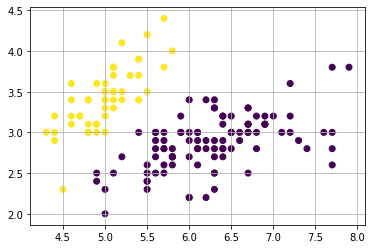

In [2]:
data = load_iris().data[:,:2]
data = np.hstack((data, np.ones((150, 1))))
target = load_iris().target < 1
target = target.astype("int") * 2 - 1
plt.scatter(data[:,0], data[:,1], c=target)
plt.grid()

* *Лэйблы должны ровнятся одному и минус одному.*  
* *Точки находящиеся по одну сторону от прямой получат положительное значение а точки по другуюсторону отрицательные.*  
* *Таким образом в результате умножения результата модели на истинные лэйблы - легко понять какие точки классифицированы не верно(если результат отрицательный).*  
* *Мы выбераем те точки чьи значения меньше еденицы, тем самым выбрав точки которые попали в зазор или были классифицированы не верно*  
* *И двигаем градиент в сторону увеличения этих значений тем самым выталкивая точки из зазора и начинаем правильно классифицировать ошибки.*  
* *Точки находящщиеся в зазоре имеют значения X @ W * Y < 1, увеличивая значения этой функции мы минимизируем колличество точек в зазоре*
* *Контролируя размер весов с помощью регуляризации - мы контролируем величину зазора, чем меньше веса - тем меньше зазор*

In [4]:
np.random.seed(0)
X = TensorData(data)
Y = TensorData(target.reshape((-1, 1)))
W = TensorData(np.random.laplace(scale=1, size=(3, 1)))

loss = (X.dot(W) * Y < 1).sum(0) + ((W) ** 2).sum(0) * .1

for i in range(100):
    loss.forward()
    loss.bprop()
    W.data += W.gradient * 0.01
    W.gradient *= 0.1

$w_1\cdot x_1 + w_2\cdot x_2 + w_3\cdot 1 = 0$

$x_2 = -\frac{w_1\cdot x_1}{w_2} - \frac{w_3\cdot 1}{w_2}$

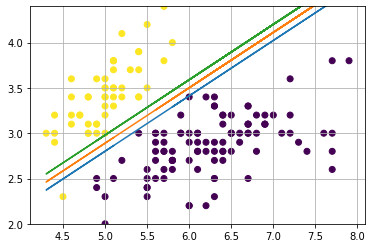

In [5]:
def get_line(w, data, bias=0):
    get_point = lambda w, p, b=0: - p * w[0] / w[1] - (w[2] + b) / w[1]
    return [get_point(w, i, bias) for i in  data]

plt.scatter(data[:,0], data[:,1], c=target.flatten())
plt.plot(data[:,0], get_line(W.data, data[:,0], 1))
plt.plot(data[:,0], get_line(W.data, data[:,0]))
plt.plot(data[:,0], get_line(W.data, data[:,0], -1))
plt.ylim(data[:,1].min(), data[:,1].max())
plt.grid()

Tensorflow
===

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


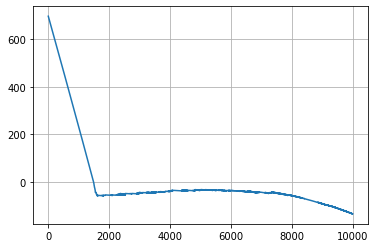

In [3]:
learning_rate = 0.001
n_steps = 10 ** 4
story_loss = []

with tf.name_scope('placeholder'):
    x = tf.placeholder(tf.float32, (150, 2))
    y = tf.placeholder(tf.float32, (150, 1))
with tf.name_scope('weghts'):
    W = tf.Variable(tf.random_normal((2, 1)))
    b = tf.Variable(tf.random_normal((1, )))
with tf.name_scope('prediction'):
    y_logit = x @ W + b
with tf.name_scope('loss'):
    l = (y_logit * y)
    mask = tf.squeeze(l < 1)
    l = -tf.reduce_sum(l[mask]) - tf.reduce_sum(W ** 2) * 2
with tf.name_scope('optimizer'):
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(l)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_steps):
        feed_dict = {x:data[:, :-1], y:target.reshape((-1, 1))}
        _, loss = sess.run([train_op, l], feed_dict=feed_dict)
        story_loss.append(loss)
    w_value = sess.run(W)
    b_value = sess.run(b)
plt.plot(story_loss)
plt.grid()

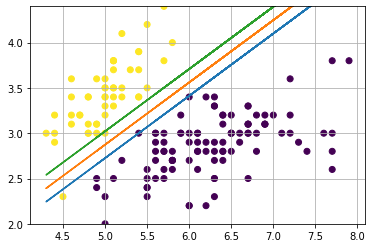

In [4]:
def get_line(w, data, bias=0):
    get_point = lambda w, p, b=0: - p * w[0] / w[1] - (w[2] + b) / w[1]
    return [get_point(w, i, bias) for i in  data]

weights = w_value[0][0], w_value[1][0], b_value[0]
plt.scatter(data[:,0], data[:,1], c=target.flatten())
plt.plot(data[:,0], get_line(weights, data[:,0], 1))
plt.plot(data[:,0], get_line(weights, data[:,0]))
plt.plot(data[:,0], get_line(weights, data[:,0], -1))
plt.ylim(data[:,1].min(), data[:,1].max())
plt.grid()

Torch
===

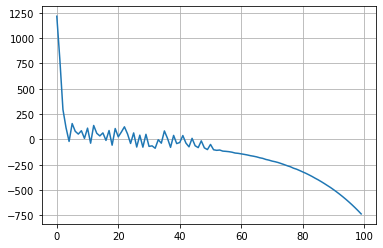

In [5]:
X = torch.Tensor(data[:, :-1])
Y = torch.Tensor(target.reshape((-1, 1)))

W = torch.randn(2, 1, requires_grad=True)
b = torch.randn(1)

story_loss = []
for i in range(100):
    out = ((X @ W + b) * Y)
    loss = out[out < 1].sum() + (W ** 2).sum() * 10
    story_loss.append(-loss.item())
    loss.backward()
    W.data += W.grad * 0.001
    W.grad *= 0.1
    
plt.plot(story_loss)
plt.grid()

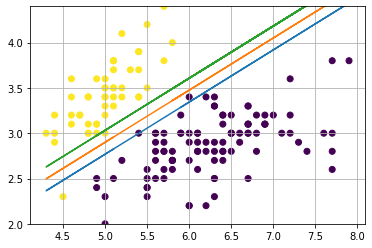

In [6]:
def get_line(w, data, bias=0):
    get_point = lambda w, p, b=0: - p * w[0] / w[1] - (w[2] + b) / w[1]
    return [get_point(w, i, bias) for i in  data]

weights = W.data[0].item(), W.data[1].item(), b.item()
plt.scatter(data[:,0], data[:,1], c=target.flatten())
plt.plot(data[:,0], get_line(weights, data[:,0], 1))
plt.plot(data[:,0], get_line(weights, data[:,0]))
plt.plot(data[:,0], get_line(weights, data[:,0], -1))
plt.ylim(data[:,1].min(), data[:,1].max())
plt.grid()